In [2]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [3]:
# Стандартные библиотеки для работы с массивами, таблицами и визуализацией
import numpy as np                          # работа с числовыми массивами и векторами
import pandas as pd                        # обработка таблиц и датафреймов
import matplotlib.pyplot as plt            # базовая визуализация графиков
import seaborn as sns                      # улучшенные графики и тепловые карты

# Модель логистической регрессии (для бинарной классификации)
from sklearn.linear_model import LogisticRegression

# Метрики для оценки качества классификации: точность, полнота, F1, AUC и матрица ошибок
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)

# Алгоритм, который относит объект к классу, наиболее часто встречающемуся среди его ближайших соседей в пространстве признаков.
from sklearn.neighbors import KNeighborsClassifier

# Градиентный бустинг от Яндекса — хорошо работает с категориальными признаками
from catboost import CatBoostClassifier

# Градиентный бустинг от XGBoost — мощная модель для работы с табличными данными
from xgboost import XGBClassifier

# Быстрый градиентный бустинг от sklearn (без внешних зависимостей)
from sklearn.ensemble import HistGradientBoostingClassifier

# Случайный лес — классический ансамблевый метод на основе деревьев
from sklearn.ensemble import RandomForestClassifier

# Функция для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split


In [6]:
# === Загружаем Датасет ===
df = pd.read_excel("/content/sample_data/1.xlsx")
df = df.drop_duplicates()
print(f"Размерность набора данных: {df.shape}")
display(df.head())
df.info()

# Альтернативный способ загрузки данных для ментора, если возникают проблемы с загрузкой файла
# Excel = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
# df = pd.read_excel(Excel)

Размерность набора данных: (1001, 214)


,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 214 entries, Unnamed: 0 to fr_urea
dtypes: float64(107), int64(107)
memory usage: 1.6 MB


In [7]:
target = 'IC50, mM'
cols_to_drop= ['CC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

Исходное количество записей: 1001


In [8]:
mean_ic50 = df[target].mean()
std_ic50 = df[target].std()
lower_bound = mean_ic50 - 2 * std_ic50
upper_bound = mean_ic50 + 2 * std_ic50

df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].copy()

filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")


Количество записей после удаления выбросов: 945
Удалено записей: 56


In [9]:
# Создание целевой переменной
df['iC50_Median'] = (df[target] > df[target].median()).astype(int)
target = 'iC50_Median'

In [10]:
RANDOM_STATE = 123

In [11]:
# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]


In [13]:
df_regress = X.copy()

# Добавление новых признаков молярный
df_regress['MolLogP_MolWt'] = df_regress['MolLogP'] * df_regress['MolWt']

In [14]:
# Полиномиальные признаки
existing_poly_cols = [col for col in ['MolLogP', 'MolWt'] if col in df_regress.columns]

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_regress[existing_poly_cols])
poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_regress.index)
for col in new_poly_df.columns:
   if col not in df_regress.columns:
       df_regress[col] = new_poly_df[col]

In [16]:
df_regress['MolLogP_gt_3'] = (df_regress['MolLogP'] > 3).astype(int)

In [17]:
imputer = SimpleImputer(strategy='median')
df_regress = pd.DataFrame(imputer.fit_transform(df_regress), columns=df_regress.columns)

In [18]:
print("Получили новые признаки:", [col for col in df_regress.columns if col not in df.columns])

Получили новые признаки: ['MolLogP_MolWt', 'MolLogP^2', 'MolLogP MolWt', 'MolWt^2', 'MolLogP_gt_3']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [20]:
results = []

**Logistic Regression**

In [21]:
#Обучение и прогноз модели логистической регрессии

name = 'Logistic Regression'
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

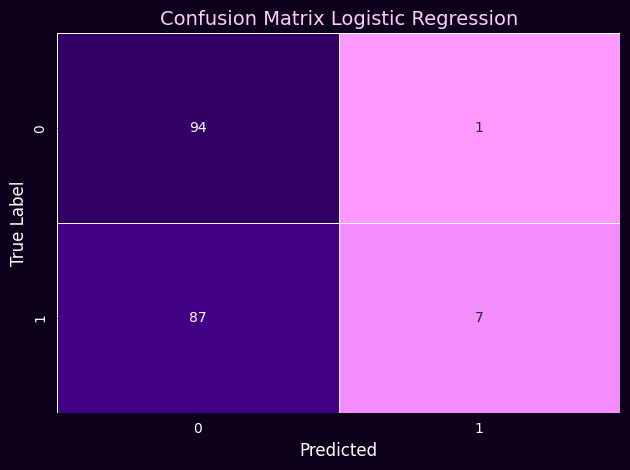

In [23]:
#Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Неоново-фиолетовый градиент
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')
plt.gcf().patch.set_facecolor('#0d001a')
plt.tight_layout()
plt.show()

In [24]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Logistic Regression',
 'Precision': 0.875,
 'Recall': 0.07446808510638298,
 'F1 Score': 0.13725490196078433,
 'Accuracy': 0.5343915343915344,
 'ROC-AUC': np.float64(0.5293952967525195)}

**KNN**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
#Обучение и прогноз модели KNN

name = 'KNN'
model =  KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

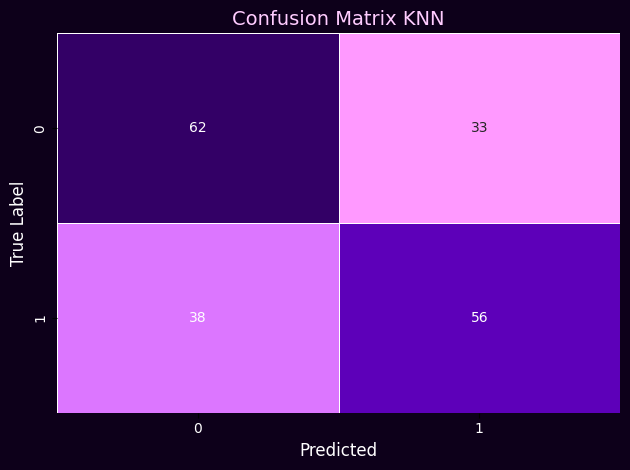

In [28]:
# Построение и визуализация confusion matrix с неоново-фиолетовым градиентом

from matplotlib.colors import LinearSegmentedColormap

# Градиент: от ярко-розового к тёмно-фиолетовому
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')           # тёмный фон под графиком
plt.gcf().patch.set_facecolor('#0d001a')     # тёмный фон фигуры
plt.tight_layout()
plt.show()

In [29]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'KNN',
 'Precision': 0.6292134831460674,
 'Recall': 0.5957446808510638,
 'F1 Score': 0.6120218579234973,
 'Accuracy': 0.6243386243386243,
 'ROC-AUC': np.float64(0.6599664053751401)}

**Random Forest**

In [30]:
#Обучение и прогноз модели Random Forest

name = 'Random Forest'
model =  RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


y_pred

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

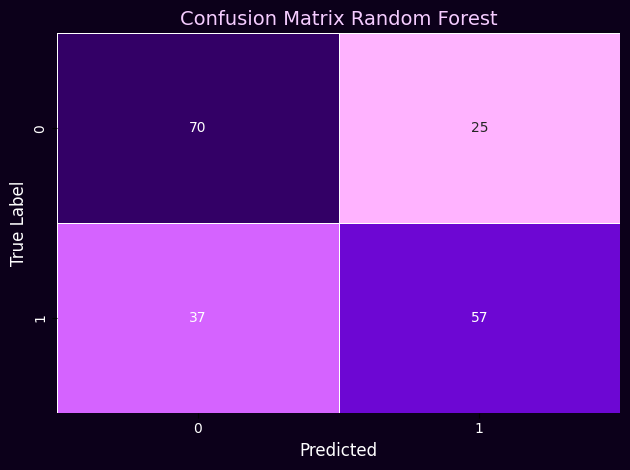

In [31]:
#Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Создание кастомной неон-фишетовой цветовой карты
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ffb3ff", "#d966ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#f5ccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0c001a')           # фон под графиком
plt.gcf().patch.set_facecolor('#0c001a')     # фон всей области
plt.tight_layout()
plt.show()

In [32]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Random Forest',
 'Precision': 0.6951219512195121,
 'Recall': 0.6063829787234043,
 'F1 Score': 0.6477272727272727,
 'Accuracy': 0.671957671957672,
 'ROC-AUC': np.float64(0.7765957446808511)}

**Gradient Boosting**

In [33]:
from sklearn.ensemble import  GradientBoostingClassifier

In [34]:
#Обучение и прогноз модели Gradient Boosting

name = 'Gradient Boosting'
model =  GradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

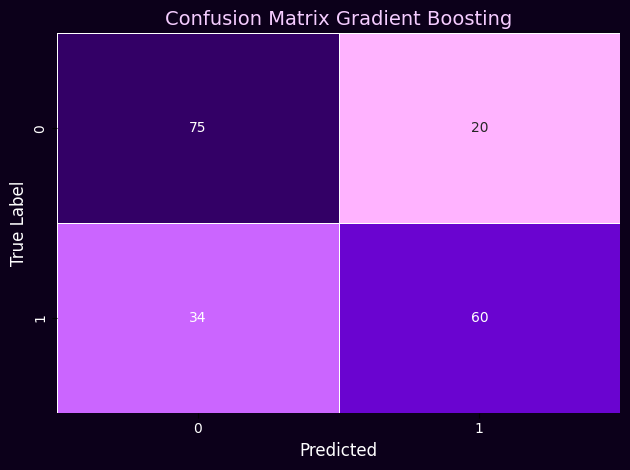

In [35]:
#Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Неоново-фиолетовый градиент
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ffb3ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#f5ccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0c001a')
plt.gcf().patch.set_facecolor('#0c001a')
plt.tight_layout()
plt.show()

In [36]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Gradient Boosting',
 'Precision': 0.75,
 'Recall': 0.6382978723404256,
 'F1 Score': 0.6896551724137931,
 'Accuracy': 0.7142857142857143,
 'ROC-AUC': np.float64(0.8094624860022396)}

**HistGradientBoosting**

In [37]:
#Обучение и прогноз модели HistGradientBoosting

name = 'HistGradientBoosting'
model =  HistGradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

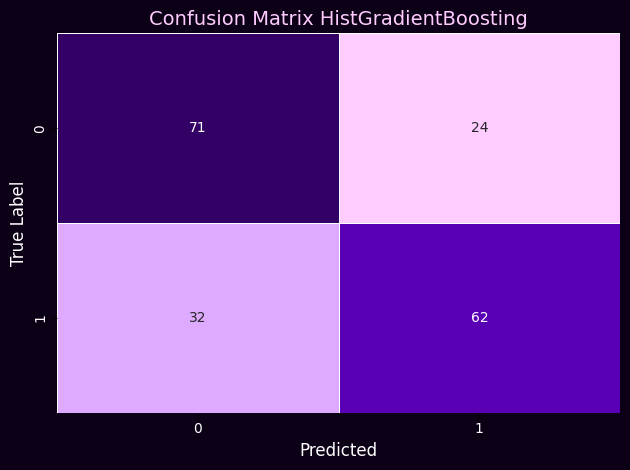

In [38]:
#Построение и визуализация confusion matrix


from matplotlib.colors import LinearSegmentedColormap

# Неоново-фиолетовая цветовая карта (градиент от розового к тёмному фиолетовому)
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ffccff", "#cc99ff", "#9966ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0b0015')           # тёмный фон графика
plt.gcf().patch.set_facecolor('#0b0015')     # тёмный фон всей фигуры
plt.tight_layout()

In [39]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'HistGradientBoosting',
 'Precision': 0.7209302325581395,
 'Recall': 0.6595744680851063,
 'F1 Score': 0.6888888888888889,
 'Accuracy': 0.7037037037037037,
 'ROC-AUC': np.float64(0.7773236282194849)}

**XGBoost**

In [40]:
from xgboost import XGBClassifier

In [41]:
#Обучение и прогноз модели логистической регрессии

name = 'XGBoost'
model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

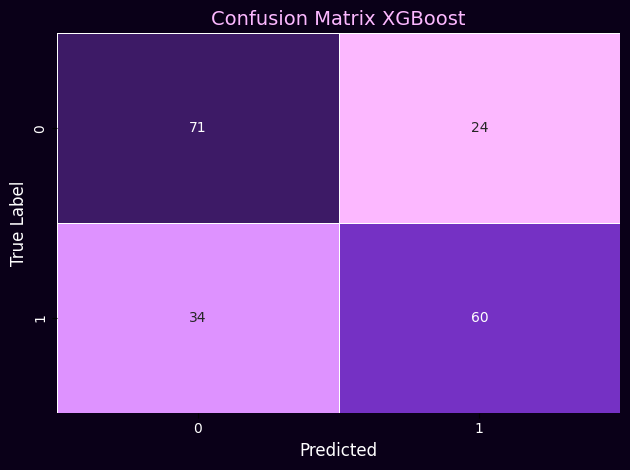

In [42]:
#Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Градиент от светло-розового к насыщенному фиолетовому
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#fcb8ff", "#d88bff", "#b266ff", "#7a33cc", "#3d1a66"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#fcb8ff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0a0018')           # тёмный фон под графиком
plt.gcf().patch.set_facecolor('#0a0018')     # тёмный фон всей фигуры
plt.tight_layout()
plt.show()

In [43]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'XGBoost',
 'Precision': 0.7142857142857143,
 'Recall': 0.6382978723404256,
 'F1 Score': 0.6741573033707865,
 'Accuracy': 0.6931216931216931,
 'ROC-AUC': np.float64(0.7732922732362821)}

**CatBoost**

In [44]:
from catboost import CatBoostClassifier

In [45]:
#Обучение и прогноз модели CatBoost

name = 'CatBoost'
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

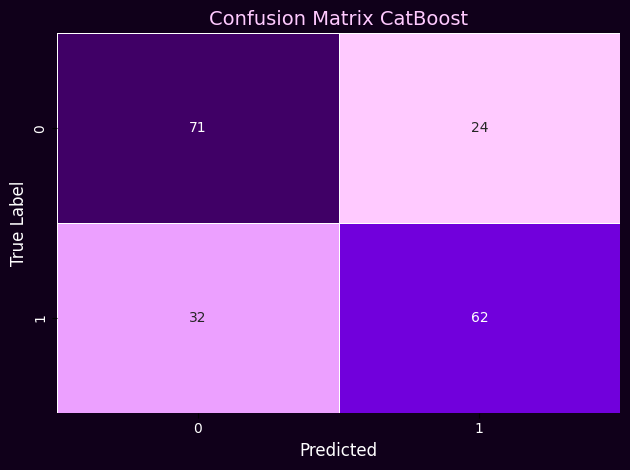

In [46]:
#Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Неоново-фиолетовая цветовая карта (от светлого розового к глубокому фиолетовому)
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ffcaff", "#e38cff", "#b84dff", "#8000ff", "#400066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffcaff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#10001a')           # тёмный фон области графика
plt.gcf().patch.set_facecolor('#10001a')     # тёмный фон всей фигуры
plt.tight_layout()
plt.show()

In [47]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'CatBoost',
 'Precision': 0.7209302325581395,
 'Recall': 0.6595744680851063,
 'F1 Score': 0.6888888888888889,
 'Accuracy': 0.7037037037037037,
 'ROC-AUC': np.float64(0.7949048152295632)}

In [48]:
results_df = pd.DataFrame(results)

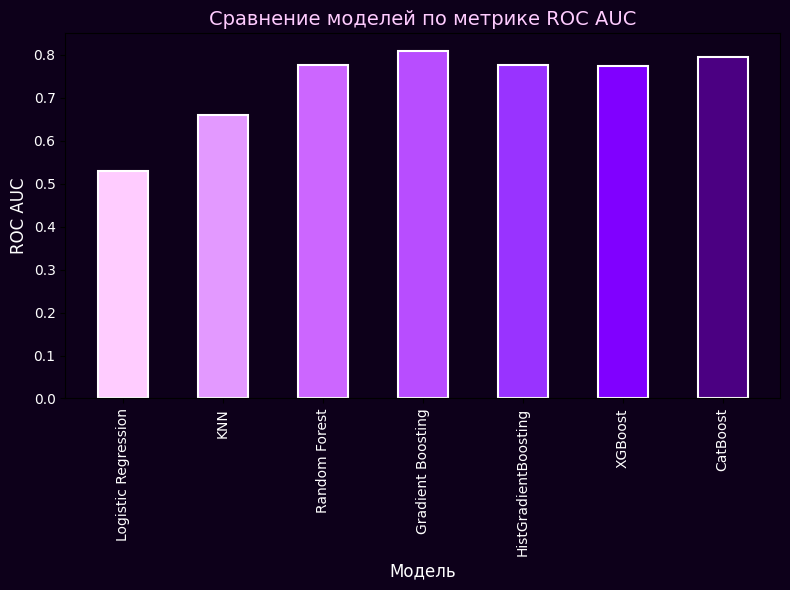

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Неоново-фиолетовый градиент вручную
colors = [
    '#ffccff',  # светло-розовый
    '#e399ff',  # сиреневый
    '#cc66ff',  # фиолетовый
    '#b84dff',  # насыщенный фиолетовый
    '#9933ff',  # глубокий фиолет
    '#8000ff',  # яркий неон
    '#4b0082'   # индиго
]

# Построение графика
plt.figure(figsize=(8, 6))
plt.title('Сравнение моделей по метрике ROC AUC', fontsize=14, color='#ffccff')

bars = plt.bar(results_df['Model'], results_df['ROC-AUC'], width=0.5, color=colors, edgecolor='white', linewidth=1.5)

# Настройка подписей и фона
plt.xticks(rotation=90, color='white')
plt.yticks(color='white')
plt.ylabel('ROC AUC', fontsize=12, color='white')
plt.xlabel('Модель', fontsize=12, color='white')
plt.gca().set_facecolor('#0d001a')            # тёмный фон под графиком
plt.gcf().patch.set_facecolor('#0d001a')      # фон всей фигуры

plt.tight_layout()
plt.show()

In [51]:
print("Результаты классификации:")
results_df

Результаты классификации:


,Model,Precision,Recall,F1 Score,Accuracy,ROC-AUC
0,Logistic Regression,0.875000,0.074468,0.137255,0.534392,0.529395
1,KNN,0.629213,0.595745,0.612022,0.624339,0.659966
2,Random Forest,0.695122,0.606383,0.647727,0.671958,0.776596
3,Gradient Boosting,0.750000,0.638298,0.689655,0.714286,0.809462
4,HistGradientBoosting,0.720930,0.659574,0.688889,0.703704,0.777324
5,XGBoost,0.714286,0.638298,0.674157,0.693122,0.773292
6,CatBoost,0.720930,0.659574,0.688889,0.703704,0.794905


In [52]:
print(f"Наилучший результат \n{results_df[results_df['ROC-AUC']==results_df['ROC-AUC'].max()]}")

Наилучший результат 
               Model  Precision    Recall  F1 Score  Accuracy   ROC-AUC
3  Gradient Boosting       0.75  0.638298  0.689655  0.714286  0.809462


* По метрике ROC-AUC наилучший результат показала модель **Gradient Boosting** (0.809).  
* Она также демонстрирует сбалансированные значения **Precision, Recall и F1 Score**, что делает её надёжным кандидатом для финального выбора.